In [8]:
#Importacion de librerias

In [32]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
import datetime


import pandas as pd 
import re
import nltk 

In [ ]:
#Cargaremos los dos conjuntos de datos, indexando por fecha.

In [17]:
import pandas as pd



counts = pd.read_csv('FremontBridge.csv', index_col='Date', parse_dates=True)
weather = pd.read_csv('BicycleWeather.csv', index_col='DATE', parse_dates=True)

In [ ]:
#A continuación, calcularemos el tráfico total diario de bicicletas y lo colocaremos en un propio marco de datos,

In [18]:
daily = counts.resample('d').sum()
daily['Total'] = daily.sum(axis=1)
daily = daily[['Total']] # remove other columns

In [ ]:
# Ahora utilizaremos nuestros datos agregando columnas binarias que indiquen el día de la semana

In [19]:
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
for i in range(7):
    daily[days[i]] = (daily.index.dayofweek == i).astype(float)

In [ ]:
#De manera similar, podríamos esperar que los pasajeros se comporten de manera diferente durante las vacaciones; agreguemos un indicador de esto también.

In [20]:
from pandas.tseries.holiday import USFederalHolidayCalendar
cal = USFederalHolidayCalendar()
holidays = cal.holidays('2012', '2016')
daily = daily.join(pd.Series(1, index=holidays, name='holiday'))
daily['holiday'].fillna(0, inplace=True)

In [ ]:
#También podríamos sospechar que las horas de luz del día afectarían la cantidad de personas que viajan; usemos el cálculo astronómico estándar para agregar esta información.

C:\Users\BRAYAN\AppData\Local\Temp\ipykernel_2692\2549717813.py:3: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  days = (date - pd.datetime(2000, 12, 21)).days


(8.0, 17.0)

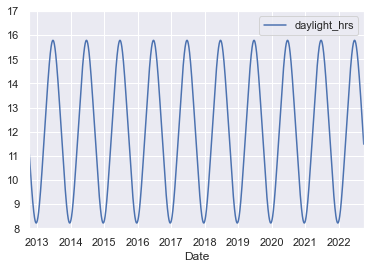

In [21]:
def hours_of_daylight(date, axis=23.44, latitude=47.61):
    """Compute the hours of daylight for the given date"""
    days = (date - pd.datetime(2000, 12, 21)).days
    m = (1. - np.tan(np.radians(latitude))
         * np.tan(np.radians(axis) * np.cos(days * 2 * np.pi / 365.25)))
    return 24. * np.degrees(np.arccos(1 - np.clip(m, 0, 2))) / 180.

daily['daylight_hrs'] = list(map(hours_of_daylight, daily.index))
daily[['daylight_hrs']].plot()
plt.ylim(8, 17)

In [ ]:
#Ahora  podemos agregar la temperatura promedio y la precipitación total a los datos. Además de las pulgadas de precipitación, agreguemos una bandera que indique si un día está seco (tiene cero precipitaciones).

In [22]:
# temperatures are in 1/10 deg C; convert to C
weather['TMIN'] /= 10
weather['TMAX'] /= 10
weather['Temp (C)'] = 0.5 * (weather['TMIN'] + weather['TMAX'])

# precip is in 1/10 mm; convert to inches
weather['PRCP'] /= 254
weather['dry day'] = (weather['PRCP'] == 0).astype(int)

daily = daily.join(weather[['PRCP', 'Temp (C)', 'dry day']])

In [ ]:
#Como paso final, agreguemos un contador que aumente desde el día 1 y mida cuántos años han pasado. Esto  permite medir cualquier aumento o disminución anual observado en los cruces diarios.

In [23]:
daily['annual'] = (daily.index - daily.index[0]).days / 365.

In [ ]:
# Ahora nuestros datos están en orden, y podemos echarles un vistazo de la siguiente manera llamando a head()

In [24]:
daily.head()

,Total,Mon,Tue,Wed,Thu,Fri,Sat,Sun,holiday,daylight_hrs,PRCP,Temp (C),dry day,annual
Date,,,,,,,,,,,,,,
2012-10-03,7042.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,11.277359,0.0,13.35,1.0,0.000000
2012-10-04,6950.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,11.219142,0.0,13.60,1.0,0.002740
2012-10-05,6296.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,11.161038,0.0,15.30,1.0,0.005479
2012-10-06,4012.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,11.103056,0.0,15.85,1.0,0.008219
2012-10-07,4284.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,11.045208,0.0,15.85,1.0,0.010959


In [ ]:
#Con esto en su lugar, podemos elegir las columnas a usar y ajustar un modelo de regresión lineal a nuestros datos. Estableceremos fit_intercept = False, porque las banderas diarias esencialmente funcionan como sus propias intersecciones específicas del día

In [27]:
import sklearn
from sklearn import linear_model
from sklearn.linear_model import LinearRegression

# Drop any rows with null values
daily.dropna(axis=0, how='any', inplace=True)

column_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun', 'holiday',
                'daylight_hrs', 'PRCP', 'dry day', 'Temp (C)', 'annual']
X = daily[column_names]
y = daily['Total']

model = LinearRegression(fit_intercept=False)
model.fit(X, y)
daily['predicted'] = model.predict(X)

In [ ]:
#Ya para entender un poco mas los datos  podemos comparar visualmente el tráfico de bicicletas total y pronosticado.

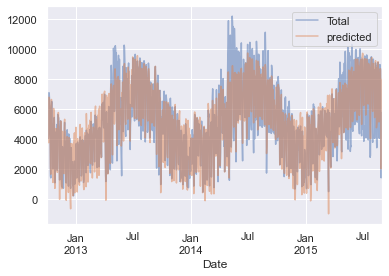

In [28]:
daily[['Total', 'predicted']].plot(alpha=0.5);

In [ ]:
#Es evidente que nos hemos perdido algunas características clave, especialmente durante el verano. Nuestras funciones no están completas (es decir, las personas deciden si ir en bicicleta al trabajo basándose en algo más que esto) o hay algunas relaciones no lineales que no hemos tenido en cuenta (p. ej., tal vez las personas viajan menos a temperaturas altas y bajas). )

In [29]:
params = pd.Series(model.coef_, index=X.columns)
params

Mon             1009.765512
Tue             1220.467872
Wed             1185.347283
Thu              964.716230
Fri              355.960691
Sat            -2206.603421
Sun            -2267.134492
holiday        -2374.802762
daylight_hrs     257.703022
PRCP           -1329.669764
dry day         1095.397185
Temp (C)         130.325582
annual            53.885426
dtype: float64

In [ ]:
#Estos números son difíciles de interpretar sin alguna medida de su incertidumbre. Podemos calcular estas incertidumbres rápidamente utilizando remuestreos de arranque de los datos

In [30]:
from sklearn.utils import resample
np.random.seed(1)
err = np.std([model.fit(*resample(X, y)).coef_
              for i in range(1000)], 0)

In [ ]:
#Con estos errores estimados, veremos nuevamente los resultados.

In [31]:
print(pd.DataFrame({'effect': params.round(0),
                    'error': err.round(0)}))

              effect  error
Mon           1010.0  173.0
Tue           1220.0  166.0
Wed           1185.0  166.0
Thu            965.0  170.0
Fri            356.0  162.0
Sat          -2207.0  159.0
Sun          -2267.0  166.0
holiday      -2375.0  326.0
daylight_hrs   258.0   18.0
PRCP         -1330.0  125.0
dry day       1095.0   66.0
Temp (C)       130.0    7.0
annual          54.0   35.0


In [ ]:
#Primero vemos que hay una tendencia relativamente estable en la línea de base semanal: hay muchos más ciclistas entre semana que los fines de semana y días festivos. Vemos que por cada hora adicional de luz diurna, 129 ± 9 personas más eligen viajar; un aumento de temperatura de un grado centígrado anima a 65 ± 4 personas a agarrar su bicicleta; un día seco significa un promedio de 548 ± 33 ciclistas más, y cada pulgada de precipitación significa que 665 ± 62 personas más dejan su bicicleta en casa. Una vez que se toman en cuenta todos estos efectos, vemos un modesto aumento de 27 ± 18 nuevos pasajeros diarios cada año.

In [ ]:
# CONCLUSION : Este logaritmo tiene herramientas muy potentes e interesantes con las cuales se pueden explorar demasiado es importante utilisar informacion relevante para las practicas, ya que  estos modelos pueden extenderse para modelar un comportamiento de datos más complicado.